# Train a Model on Flyte

First, install the necessary packages:

In [ ]:
%pip install "flytekit==1.14.4" matplotlib "pydantic>2" pandas pyarrow scikit-learn joblib

In [1]:
import os

os.environ["AWS_ACCESS_KEY_ID"] = "minio"
os.environ["AWS_SECRET_ACCESS_KEY"] = "miniostorage"
os.environ["AWS_ENDPOINT_URL"] = "http://localhost:30002"

## Create a Dataset

The following code creates a dataset for us to train a model on:

In [8]:
import flytekit as fl
import pandas as pd
import sys


image = fl.ImageSpec(
    name="jupyter-notebook-workshop",
    packages=[
        "pandas",
        "pyarrow",
        "flytekit==1.14.4",
    ],
    registry="localhost:30000",
    python_version=f"{sys.version_info.major}.{sys.version_info.minor}",
)

task = fl.task(container_image=image)


@task
def get_df() -> pd.DataFrame:
    """Returns a new Dataframe with cols [Name, Age, Grade and PassedTest]"""
    return pd.DataFrame({
        'Name': ['Alice', 'Bob', 'Charlie', 'David', 'Eva'],
        'Age': [23, 25, 22, 24, 23],
        'Grade': ['A', 'B', 'A', 'C', 'B'],
        'PassedTest': [True, False, True, False, True]
    })

Next we create a remote client that can execute tasks on Union Serverless:

In [9]:
remote = fl.FlyteRemote.for_sandbox(
    default_project="flytesnacks",
    default_domain="development",
    interactive_mode_enabled=True,
)

exe = remote.execute(get_df, inputs={})
exe

14:06:01.868945 WARNING  remote.py:286 - Jupyter notebook and interactive task  
                         support is still alpha.

Flyte Serialized object (FlyteWorkflowExecution):
  id:
    project: flytesnacks
    domain: development
    name: ajnc7mkhmz49jm4dq2g6
  spec:
    launch_plan:
      resource_type: 1
      project: flytesnacks
      domain: development
      name: get_df
      version: h3x2aCgsidcA6Qis4II8_g
    metadata:
  closure:
    created_at:
      seconds: 1737140761
      nanos: 929963000
    updated_at:
      seconds: 1737140761
      nanos: 929963000

Wait for the execution to complete, then load the dataframe into memory:

In [10]:
exe.wait(poll_interval=1)
dataframe = exe.outputs['o0']
dataframe

,Name,Age,Grade,PassedTest
0,Alice,23,A,True
1,Bob,25,B,False
2,Charlie,22,A,True
3,David,24,C,False
4,Eva,23,B,True


You can now play around with the dataframe directly in the jupyter runtime:

In [11]:
def local_function(dataframe: pd.DataFrame):
    return dataframe.groupby("Grade")["Age"].sum()

local_function(dataframe)

Grade
A    45
B    48
C    24
Name: Age, dtype: int64

## Train a Model

Next we define a task that trains a model:

In [6]:
from flytekit.types.file import FlyteFile


training_task = fl.task(container_image=image.with_packages(["scikit-learn", "joblib"]))

@training_task
def train_model(dataframe: pd.DataFrame) -> FlyteFile:
    import joblib
    from sklearn.linear_model import LogisticRegression

    model = LogisticRegression()
    model.fit(dataframe[["Age"]], dataframe["PassedTest"])

    with open("model.pkl", "wb") as f:
        joblib.dump(model, f)

    return FlyteFile(path="model.pkl")


@fl.workflow
def train_workflow(dataframe: pd.DataFrame) -> FlyteFile:
    # dataframe = get_df()
    return train_model(dataframe)

Execute the training run:

In [12]:
model_exe = remote.execute(train_workflow, inputs={"dataframe": dataframe})
model_exe

Image localhost:30000/jupyter-notebook-workshop:HHvu5bNFvQU_nl_8153l9Q found. Skip building.


╭─────────────────────────────────────── Traceback (most recent call last) ───────────────────────────────────────╮
│ /Users/nielsbantilan/miniforge3/envs/jupyter-notebook-workshop/lib/python3.11/site-packages/flytekit/remote/rem │
│ ote_fs.py:85 in _upload_chunk                                                                                   │
│                                                                                                                 │
│ ❱  85 │   │   │   │   raise AssertionError(f"Failed to upload file {self._filename} to {res.si                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
AssertionError: Failed to upload file 00000 to 
http://localhost:30002/my-s3-bucket/flytesnacks/development/00000/ldhxhrbz9g42f7vnvxnj?X-Amz-Algorithm=AWS4-HMAC-SH
A256&X-Amz-Credential=minio%2F20250117%2Fus-east-1%2Fs3%2Faws4_request&X-Amz-Date=20250117T190623Z&X-Amz-Expires=36
00&X-Amz-SignedHeaders=host%3Bx-amz-meta-flytecontentmd5&X-Amz-Signature=50d1ff00198e731452b15bdc1ee9e19a8c937524ad
55e2ea5275549b937c776b reason Bad Request

During handling of the above exception, another exception occurred:

╭─────────────────────────────────────── Traceback (most recent call last) ───────────────────────────────────────╮
│ in <module>:1                                                                                                   │
│                                                                                                                 │
│ ❱ 1 model_exe = remote.execute(train_workflow, inputs={"dataframe": dataframe})                                 │
│                                                                                                                 │
│ /Users/nielsbantilan/miniforge3/envs/jupyter-notebook-workshop/lib/python3.11/site-packages/flytekit/remote/rem │
│ ote.py:1666 in execute                                                                                          │
│                                                                                                                 │
│ ❱ 1666 │   │   │   return self.execute_local_workflow(                                                          │
│                                                                                                                 │
│ /Users/nielsbantilan/miniforge3/envs/jupyter-notebook-workshop/lib/python3.11/site-packages/flytekit/remote/rem │
│ ote.py:2102 in execute_local_workflow                                                                           │
│                                                                                                                 │
│ ❱ 2102 │   │   return self.execute(                                                                             │
│                                                                                                                 │
│ /Users/nielsbantilan/miniforge3/envs/jupyter-notebook-workshop/lib/python3.11/site-packages/flytekit/remote/rem │
│ ote.py:1569 in execute                                                                                          │
│                                                                                                                 │
│ ❱ 1569 │   │   │   return self.execute_remote_task_lp(                                                          │
│                                                                                                                 │
│ /Users/nielsbantilan/miniforge3/envs/jupyter-notebook-workshop/lib/python3.11/site-packages/flytekit/remote/rem │
│ ote.py:1728 in execute_remote_task_lp                                                                           │
│                                                                                                                 │
│ ❱ 1728 │   │   return self._execute(                                                                            │
│           

Now let's loads the model into the jupyter runtime:

In [17]:
import joblib

model_exe.wait(poll_interval=1)
model_file = model_exe.outputs['o0']

with open(model_file, "rb") as f:
    model = joblib.load(f)

model

LogisticRegression()

Finally, we generate some predictions with the model:

In [24]:
prediction_data = pd.DataFrame({
    "Age": [23, 25, 22, 24, 23, 18, 30, 31, 33]
})

probs = model.predict_proba(prediction_data)

<Axes: ylabel='Frequency'>

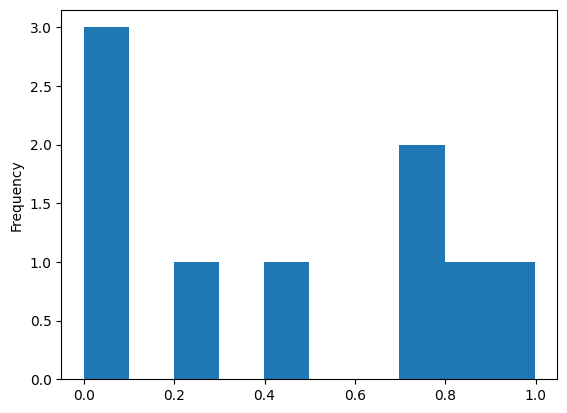

In [26]:
pd.Series(probs[:, 1]).plot.hist()